# LA Rent Distribution Changes

I compare the distribution of rents between 2009-2013 and 2013-2017 ACS surveys at the block group level in LA County. I believe this is a better metric of change than comparing changes in median rents because my metric explicitly accounts for the disappearance of low cost units and their replacement with high cost units. 

I want an index that shows whether the rent distribution has shifted upward or downward across the years but I do not have micro level data. Moreover, using this index, I wish to compare the size and direction of the shift between geographies so that geographies with a high index experienced a rightward shift in the rent distribution (thus became more expensive) while geographies with a low index experienced a leftward shift in the rent distribution (thus became less expensive). I am not aware of any such metrics so I propose one here and map it.

In order to construct a metric for distributional change without actually having micro-level data, I 1) normalize bins for each block group, 2) take the difference between the 2017 and 2013 bins, and 3) take the difference between changes in the top two bins against the changes in the bottom two bins. Let b index the 8 bins (ie rent300 to 599 is bin 2, rent 2000 or more is bin 8), i index block groups, and t index survey years . In order to avoid overlap, I exclude the ACS 2011-2015 from the index so in effect, I only use the 2009-2013 and 2013-2017 ACS surveys for the index. 

   1. For share $$s_{bit} = \frac{n_{bit}}{N_it}$$ where $1= \sum_{b} s_{bit}$. For example, if there are $N_i=100$ units in block group i and 20 units are rented for 600-799 dollars ($n_{3i}=20$) then $s_{3i}=.2$. This makes the distributions more comparable across the years.

   2. For the difference in bins, $$d_{bi} = s_{bit} - s_{bi t-1}$$
   
   3. My change index is simply $$I_i = (d_{7i}+d_{8i}) - (d_{3i}+d_{4i})$$
   

Note that $I_i\in [-2,2]$. If there is no change then, $I_i = 0$, if all high-cost units became low-cost then $I_i = -2$. If all units shift from low cost units to high cost units then $I_i=2$.

### Caveats

This may seem obvious but I wish to cover my tracks. The index cannot show why the rent distribution of an area has changed. It can only show the magnitude and size of the shift of an area's rent distribution because it uses aggregated data instead of a panel on unit-level changes in rents. For example, in the extreme of a full shift toward expensive units, for all I know, low cost units could have been torn down and replaced by a parking lot or shut down by the regulators for inadequate conditions while in the same block group, high cost units were developed. Of course, there are many other possibilities for why the distribution could change. For example, if a developer reduces all low cost units to ruble and replaces them with a higher cost complex then we'd observe the same outcome. It could be that the low cost units were remodeled so are being charged high rents or it could be that without any changes, the same unchanged unit is simply being charged a much higher rent because the landlord can. In brief, the reason why we observe a change in the rent distribution is ambiguous. 

### Data
I downloaded the 2009-2013, 2011-2015, and 2013-2017 5-year sample ACS data on tenure, gross rent, and median rent from [socialexplorer](https://www.socialexplorer.com/explore-tables). The intention was to download rents by bedroom but the ACS cutoffs are a joke when it comes to CA. The observations are censored above $1,000 which, for CA, renders the data useless. For mapping my index, I use TIGER shapefiles for block groups from the [Census](https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2010&layergroup=Block+Groups).

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

data_path = "C:/Users/SpiffyApple/Documents/USC/myblog/notebooks/rents"

In [2]:
## load data and prep
data_dict = {}

for year in [2013, 2015, 2017]:
    # set FIP as the index and drop the first row
    data_dict[year] = pd.read_csv("/".join([data_path, 'acs%s.csv'%year]), index_col='FIPS').iloc[1:]
    # there are 56 geo-coding columns..drop 'em
    data_dict[year] = data_dict[year].iloc[:,56:] 
    # simplify column names
    data_dict[year].columns =  data_dict[year].columns.str.replace("Renter-Occupied Housing Units with Cash |\:|\$|\s|,",'')
    # that first row messes things up so data are loaded as strings
    data_dict[year] = data_dict[year].astype(np.float)
    
    # take out block groups with 0 renters
    data_dict[year] = data_dict[year][data_dict[year].Rent>5]
    
    # turn rent numbers into percentages
    n = data_dict[year].shape[0]
    data_dict[year].iloc[:,2:-1] = np.divide(data_dict[year].iloc[:,2:-1],data_dict[year].iloc[:,1].values.reshape(n,1))

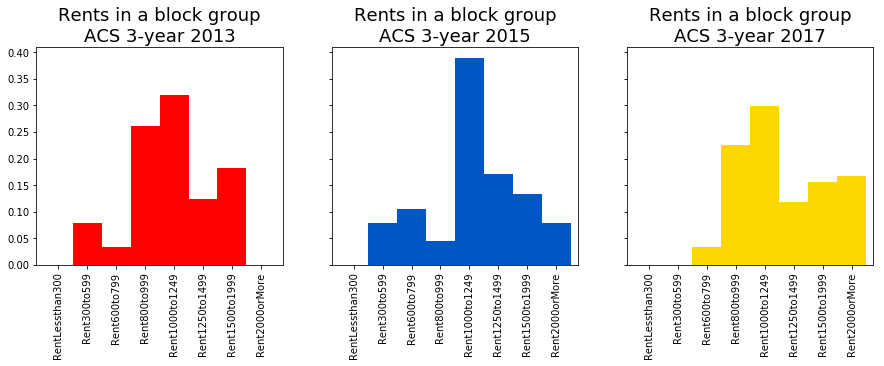

In [3]:
fig, axes  = plt.subplots(1,3, sharey=True)
palette = iter(plt.cm.prism(np.linspace(0,1,5)))

for ax, year in zip(axes.flatten(), [2013,2015,2017]):
    (data_dict[year].iloc[0,2:-1]).plot(kind='bar', width=1, ax=ax, color=next(palette))
    ax.set_title('Rents in a block group\nACS 3-year %d' %year, fontsize=18)

    fig.set_figwidth(15)    

In [4]:
## how do the columnd behave on average?
(data_dict[2017].iloc[:,2:-1] - data_dict[2013].iloc[:,2:-1]).mean()

RentLessthan300   -0.003151
Rent300to599      -0.005533
Rent600to799      -0.023273
Rent800to999      -0.033681
Rent1000to1249    -0.009718
Rent1250to1499     0.001950
Rent1500to1999     0.026048
Rent2000orMore     0.047358
dtype: float64

In [5]:
## need to make a single metric out of the differences
diffs = ((data_dict[2017].iloc[:,2:-1] - data_dict[2013].iloc[:,2:-1]))

In [6]:
# compute the index
mags = (diffs.Rent2000orMore+diffs.Rent1500to1999) - (diffs.Rent600to799 + diffs.Rent800to999)

## Check the work. 

See if the highest and lowest distributional changes are reflected in graphs

Highest index value: 2.0
Lowest index value: -2.0


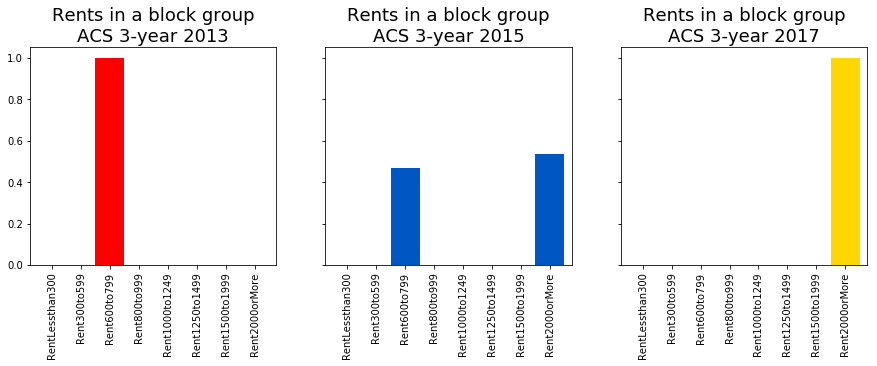

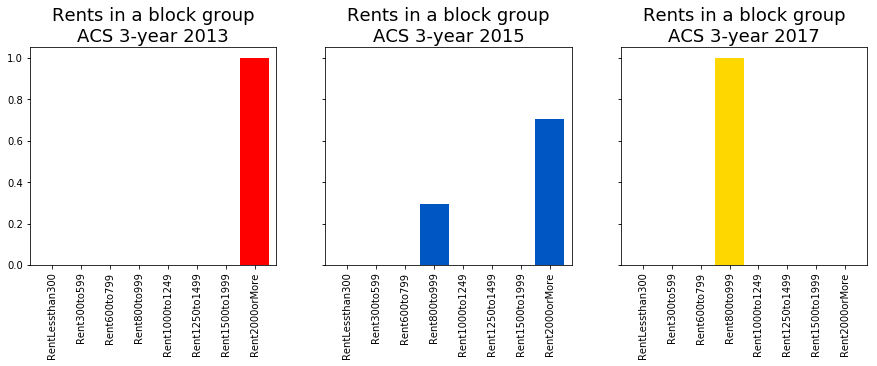

In [7]:
fig, axes  = plt.subplots(1,3, sharey=True)
palette = iter(plt.cm.prism(np.linspace(0,1,5)))

print("Highest index value: %.1f" %mags.max())
for ax, year in zip(axes.flatten(), [2013,2015,2017]):
    
    (data_dict[year].loc[mags.idxmax()].iloc[2:-1]).plot(kind='bar', width=1, ax=ax, color=next(palette))
    ax.set_title('Rents in a block group\nACS 3-year %d' %year, fontsize=18)
    fig.set_figwidth(15)    
    
fig, axes  = plt.subplots(1,3, sharey=True)
palette = iter(plt.cm.prism(np.linspace(0,1,5)))

print("Lowest index value: %.1f" %mags.min())
for ax, year in zip(axes.flatten(), [2013,2015,2017]):
    (data_dict[year].loc[mags.idxmin()].iloc[2:-1]).plot(kind='bar', width=1, ax=ax, color=next(palette))
    ax.set_title('Rents in a block group\nACS 3-year %d' %year, fontsize=18)

    fig.set_figwidth(15)        

# Comparison with Median Rent Changes

Is the above any better than changes in the median rent? Lets compare change ranks

In [8]:
## compute the metric
medDiffs = data_dict[2017].MedianGrossRent - data_dict[2013].MedianGrossRent

In [9]:
print("Block group with biggest change in median rent: %s" %medDiffs.idxmax())
print("It's corresponding rank is: %d" %medDiffs.rank().loc[medDiffs.idxmax()])

Block group with biggest change in median rent: 060374642004
It's corresponding rank is: 5412


The maximum rank is 5412 but there are 6349 block groups in LA County - could it be that null values are dropped? 

In [10]:
print("Number of observations: %d" %medDiffs.shape[0])
print("Number of missing observations: %d" %medDiffs.isnull().sum())

Number of observations: 6349
Number of missing observations: 937


## Plot Ranks 

Below, I plot the rank of median rent changes against distributional change ranks in a scatter plot. If the lined up perfectly then we'd see a perfect correlation. Clearly, that is not the case as the two do not align. High distributional changes are not picked up by changes in median rents. In essence, the 100% changes in distribution picked up by my index, and showed up(insert link), would not be picked up by the median rent changes. 

Text(0, 0.5, 'Median Rent Difference  Rank')

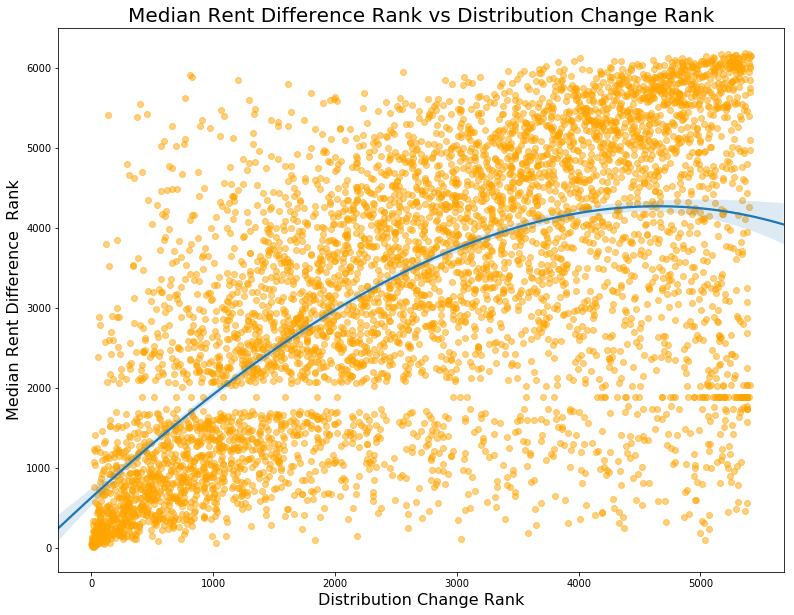

In [11]:
plt.figure(figsize=(13,10))
sns.regplot(x = medDiffs.rank(), y = mags.rank(), scatter_kws={'alpha':.5, 'color':'orange'},order=3)
plt.title('Median Rent Difference Rank vs Distribution Change Rank', fontsize=20)
plt.xlabel("Distribution Change Rank", fontsize=16)
plt.ylabel("Median Rent Difference  Rank", fontsize=16)

In [30]:
## dump the two datasets for merged with Tiger files and use in GIS software to map the data:
outDF = pd.concat([medDiffs, mags],axis=1) #combine the two datasets
outDF.columns = ['changeInRent','changeInDistribution'] #rename columns
#outDF.index = outDF.index.astype(np.int64) #make FIPS 64bit integer

## add 'b' to all indexes where values are NULL to force GIS software to read in FIPS as strings
outDF.reset_index(inplace=True)
outDF.loc[outDF.changeInDistribution.isnull(),'FIPS'] = outDF.loc[outDF.changeInDistribution.isnull(),'FIPS']+"b"
outDF.to_csv("/".join([data_path, 'rentChanges.csv']))